In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abtem.ionization import SubshellTransitions, TransitionPotential, EELSDetector
from abtem import SMatrix, Potential, GridScan

from ase import units
from ase.io import read


In [2]:
Z = 26 # atomic number
n = 2 # principal quantum number
l = 1 # azimuthal quantum number
xc = 'PBE' # exchange-correlation functional

O_transitions = SubshellTransitions(Z = Z, n = n, l = l, xc = 'PBE',epsilon=1e4,order=2)

print('bound electron configuration:', O_transitions.bound_configuration)
print('ionic electron configuration:', O_transitions.excited_configuration)



bound electron configuration: 1s2 2s2 2p6 3s2 3p6 3d6 4s2
ionic electron configuration: 1s2 2s2 2p5 3s2 3p6 3d6 4s2


In [3]:


# from scipy.fft import fft, ifft
# # u=O_transitions.get_continuum_waves()[1](r)
# u=O_transitions.get_bound_wave()(r)

# v = fft(u)

# fig, ax = plt.subplots(1,1,figsize=(6, 4))
# ax.plot(v[:100])
# plt.show()


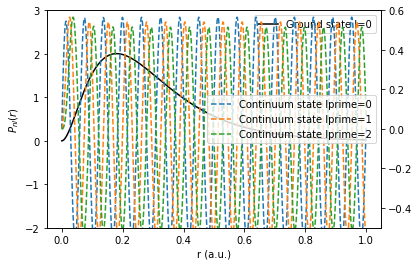

In [3]:
rmax=1
r = np.linspace(0, rmax, 10000)

from ase import units
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(r,O_transitions.get_bound_wave()(r),'k-',label='Ground state l=0')
ylim = [-2,3]
ax.set_ylim(ylim)
ax.set_xlabel("r (a.u.)")
ax.set_ylabel("$P_{nl}(r)$")
plt.legend()

ax2 = ax.twinx()
ylim = [-0.5, 0.6]
ax2.set_ylim(ylim)
for i in range(3):
    x = O_transitions.get_continuum_waves()[i](r)
    # y = O_transitions.get_continuum_waves()[1](r)
    ax2.plot(r,x,'--',label='Continuum state lprime='+str(i))

# ax.plot(r,np.sin(O_transitions.kc*r),label='Asymptotic sin wave')
# plt.xlabel('Distance (Bohr radius)')
# plt.ylabel('Raidal wave function')
plt.legend()
# plt.show()

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
class orbital:
    """
    A class for storing the results of a fac atomic structure calculation.

    When initialized this class will calculate the wave function of a bound
    electron using the flexible atomic code (fac) atomic structure code and
    store the necessary information about the radial electron wave function.
    """

    def __init__(self, Z: int, config: str, n: int, ell: int, epsilon=1):
        """
        Initialize the orbital class and return an orbital object.

        Parameters
        ----------
        Z : int
            Atomic number
        config : str
            String describing configuration of atom ie:
            carbon (C): config = '1s2 2s2 2p2'
        n : int
            Principal quantum number of orbital, for continuum wavefunctions
            pass n=0
        ell : int
            Orbital angular momentum quantum number of orbital
        epsilon : Optional, float
            Energy of continuum wavefunction in eV (only matters if n == 0)
        """
        # Load arguments into orbital object
        self.Z = Z
        self.config = config
        self.n = n
        self.ell = ell
        assert ell > -1, (
            "Angular momentum quantum number ell = " + str(ell) + ". Must be > 0"
        )
        if self.n == 0:
            assert epsilon > 0, "Energy of continuum electron must be > 0"
            self.epsilon = epsilon

        # Use pfac (Python flexible atomic code) interface to
        # communicate with underlying fac code
        import pfac.fac

        # Get atom
        pfac.fac.SetAtom(pfac.fac.ATOMICSYMBOL[Z])
        if n == 0:
            configstring = pfac.fac.ATOMICSYMBOL[Z] + "ex"
        else:
            configstring = pfac.fac.ATOMICSYMBOL[Z] + "bound"
        # Set up configuration
        pfac.fac.Config(configstring, config)
        # Optimize atomic energy levels
        pfac.fac.ConfigEnergy(0)
        # Optimize radial wave functions
        pfac.fac.OptimizeRadial(configstring)
        # Optimize energy levels
        pfac.fac.ConfigEnergy(1)

        # Orbital title
        if n > 0:
            # Bound wave function case
            angmom = ["s", "p", "d", "f"][ell]
            # Title in the format "Ag 1s", "O 2s" etc..
            self.title = "{0} {1}{2}".format(pfac.fac.ATOMICSYMBOL[Z], n, angmom)
        else:
            # Continuum wave function case
            # Title in the format "Ag e = 10 eV l'=2" etc..
            self.title = "{0} e = {1} l' = {2}".format(
                pfac.fac.ATOMICSYMBOL[Z], epsilon, ell
            )

        # Calculate relativstic quantum number from
        # non-relativistic input
        kappa = -1 - ell

        # Output desired wave function from table
        pfac.fac.WaveFuncTable("orbital.txt", n, kappa, epsilon)

        # Clear table
        # ClearOrbitalTable ()
        pfac.fac.Reinit(config=1)

        with open("orbital.txt", "r") as content_file:
            content = content_file.read()

        self.ilast = int(re.search("ilast\\s+=\\s+([0-9]+)", content).group(1))
        self.energy = float(re.search("energy\\s+=\\s+([^\\n]+)\\n", content).group(1))
        # Load information into table
        table = np.loadtxt("orbital.txt", skiprows=15)

        # Load radial grid (in atomic units)
        self.r = table[:, 1]

        # Load large component of wave function
        self.wfn_table = table[: self.ilast, 4]

        from scipy.interpolate import interp1d

        if self.n == 0:
            # If continuum wave function also change normalization units from
            # 1/sqrt(k) in atomic units to units of 1/sqrt(Angstrom eV)
            # Hartree atomic energy unit in eV
            Eh = 27.211386245988
            # Fine structure constant
            alpha = 7.2973525693e-3
            # Convert energy to Hartree units
            eH = epsilon / Eh
            # wavenumber in atomic units
            ke = np.sqrt(2 * eH * (1 + alpha ** 2 * eH / 2))
            # Normalization used in flexible atomic code
            facnorm = 1 / np.sqrt(ke)
            # Desired normalization from Manson 1972
            norm = 1 / np.sqrt(np.pi) / (epsilon / Ry) ** 0.25

            # If continuum wave function load phase-amplitude solution
            self.__amplitude = interp1d(
                table[self.ilast - 1 :, 1],
                table[self.ilast - 1 :, 2] / facnorm * norm,
                fill_value=0,
            )
            self.__phase = interp1d(
                table[self.ilast - 1 :, 1], table[self.ilast - 1 :, 3], fill_value=0
            )
            self.wfn_table *= norm / facnorm

        # For bound wave functions we simply interpolate the
        # tabulated values of a0 the wavefunction
        # *2
        self.__wfn = interp1d(
            table[: self.ilast, 1], table[: self.ilast, 4], kind="cubic", fill_value=0
        )

    def __call__(self, r):
        """Evaluate radial wavefunction on grid r from tabulated values."""
        is_arr = isinstance(r, np.ndarray)

        if is_arr:
            r_ = r
        else:
            r_ = np.asarray([r])

        # Initialize output array
        wvfn = np.zeros(r_.shape, dtype=np.float)

        # Region I and II refer to the two solution regions used in the
        # Flexible Atomic Code for continuum wave functions. Region I
        # (close to the nucleus) is where the radial Dirac equation is
        # solved with a numerical integration using the Numerov algorithm.
        # In Region II, a phase-amplitude solution is used.

        # For bound wave functions, or for r in region I for
        # a continuum wave function we simply interpolate the
        # tabulated values of the wavefunction
        mask = np.logical_and(self.r[0] <= r_, r_ < self.r[self.ilast - 1])
        wvfn[mask] = self.__wfn(r_[mask])

        # For bound atomic wave functions our work here is done...
        if self.n > 0:
            return wvfn

        # For a continuum wave function inbetween region I and II
        # interpolate between the regions
        mask = np.logical_and(
            r_ >= self.r[self.ilast - 1], r_ <= self.r[self.ilast + 1]
        )
        if np.any(mask):
            r1 = self.r[self.ilast - 1]
            r2 = self.r[self.ilast + 1]
            # Phase amplitude
            PA = self.__amplitude(r2) * np.sin(self.__phase(r2))
            # Tabulated
            TB = self.__wfn(r1)
            wvfn[mask] = (PA - TB) / (r2 - r1) * (r_[mask] - r1) + TB

        # For a continuum wave function and r in region II
        # interpolate amplitude and phase
        # wvfn[:] = 0.0
        mask = r_ > self.r[self.ilast + 1]
        wvfn[mask] = self.__amplitude(r_[mask]) * np.sin(self.__phase(r_[mask]))
        if is_arr:
            return wvfn
        else:
            return wvfn[0]

    def plot(self, grid=None, show=True, ylim=None, fig=None, plotkwargs={}):
        """Plot wavefunction at positions given by grid r in Bohr radii."""
        if fig is None:
            fig, ax = plt.subplots(figsize=(4, 4))
        else:
            ax = fig.get_axes()[0]
        if grid is None:
            rmax = max(2.0, self.r[self.ilast - 1])
            grid = np.linspace(0.0, rmax, num=50)

        wavefunction = self(grid)
        ax.plot(grid, wavefunction, **plotkwargs, label=self.title)
        # ax.set_title(self.title)
        if ylim is None:
            ylim_ = [1.2 * np.amin(wavefunction), 1.2 * np.amax(wavefunction)]
        else:
            ylim_ = ylim
        ax.set_ylim(ylim_)
        ax.set_xlim([np.amin(grid), np.amax(grid)])
        ax.set_xlabel("r (a.u.)")
        ax.set_ylabel("$P_{nl}(r)$")
        if show:
            plt.show(block=True)
        return fig

In [2]:

Z = 14
bound_config = "1s2 2s2 2p6 3s2 3p2"
excited_config = "1s2 2s2 2p6 3s2 3p2"
n = 1
ell = 0
ylim = [-0.28, 0.41]
# ylim = [-1.2,1.2]
epsilon = 10
grid = np.linspace(0.0, 1.0)
bound = orbital(Z, bound_config, n, ell)

# Initialize plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(grid, bound(grid), "k-")
ax.set_ylim([-2, 3])
ax.set_xlim([np.amin(grid), np.amax(grid)])
ax.set_xlabel("r (a.u.)")
ax.set_ylabel("$P_{nl}(r)$")

ax2 = ax.twinx()
ax2.set_ylim(ylim)
for ell in [0, 1, 2]:
    excited = orbital(Z, excited_config, 0, ell, epsilon)
    ax2.plot(grid, excited(grid), "k--")

plt.show(block=False)
fig.savefig("Dwyer_Fig1_replication.pdf")

In [5]:
for bound_state, continuum_state in O_transitions.get_transition_quantum_numbers():
    print(f'(l, ml) = {bound_state} -> {continuum_state}')



(l, ml) = (0, 0) -> (1, -1)
(l, ml) = (0, 0) -> (1, 0)
(l, ml) = (0, 0) -> (1, 1)


In [6]:
atomic_transition_potentials = O_transitions.get_transition_potentials(extent = 5,
                                                                       gpts = 256,
                                                                       energy = 100e3)


Transitions: 100%|██████████| 3/3 [00:00<00:00, 3614.74it/s] 


In [7]:
# O_transitions = SubshellTransitions(Z = Z, n = n, l = l, xc = 'PBE',epsilon=100)
# atomic_transition_potentials = O_transitions.get_transition_potentials(extent = 5,
#                                                                        gpts = 256,
#                                                                        energy = 100e3)
                                                                       

In [8]:
atomic_transition_potentials[0].measure().intensity().array

array([[3.12742851e-24, 3.36891758e-17, 1.34839176e-16, ...,
        3.03735896e-16, 1.34845735e-16, 3.36919194e-17],
       [3.37110530e-17, 6.74970672e-17, 1.68946814e-16, ...,
        3.38364816e-16, 1.68952490e-16, 6.75004380e-17],
       [1.34882950e-16, 1.68968909e-16, 2.71340229e-16, ...,
        4.42344045e-16, 2.71346697e-16, 1.68971606e-16],
       ...,
       [3.03674753e-16, 3.38282904e-16, 4.42246211e-16, ...,
        6.15963313e-16, 4.42252142e-16, 3.38286405e-16],
       [1.34804674e-16, 1.68892227e-16, 2.71265592e-16, ...,
        4.42275713e-16, 2.71272282e-16, 1.68895033e-16],
       [3.36715232e-17, 6.74575062e-17, 1.68910051e-16, ...,
        3.38331045e-16, 1.68915837e-16, 6.74609319e-17]])

In [9]:
from abtem.measure import Measurement, calibrations_from_grid
intensity = None
for t in atomic_transition_potentials:
    pot = t.measure().intensity().array
    if intensity is None:
        intensity = pot
    else:
        intensity += pot
# calibrations = (atomic_transition_potentials[0].gpts, atomic_transition_potentials[0].sampling, ['x', 'y'])
# Measurement(intensity, calibrations).show()
# atomic_transition_potentials[1].measure().intensity().show()
# np.array(t)
# plt.imshow(t)

In [10]:
intensity

array([[2.85125521e-13, 2.85340829e-13, 2.85987131e-13, ...,
        2.87065661e-13, 2.85987131e-13, 2.85340829e-13],
       [2.85340831e-13, 2.85556453e-13, 2.86203718e-13, ...,
        2.87283931e-13, 2.86203718e-13, 2.85556453e-13],
       [2.85987133e-13, 2.86203719e-13, 2.86853935e-13, ...,
        2.87939290e-13, 2.86853934e-13, 2.86203719e-13],
       ...,
       [2.87065660e-13, 2.87283928e-13, 2.87939287e-13, ...,
        2.89033513e-13, 2.87939287e-13, 2.87283929e-13],
       [2.85987133e-13, 2.86203719e-13, 2.86853934e-13, ...,
        2.87939290e-13, 2.86853935e-13, 2.86203719e-13],
       [2.85340831e-13, 2.85556453e-13, 2.86203718e-13, ...,
        2.87283931e-13, 2.86203718e-13, 2.85556453e-13]])

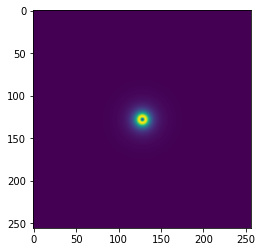

In [11]:
plt.imshow(intensity)


In [12]:
from scipy import integrate

f = lambda x: x**8

integrate.quadrature(f, 0.0, 1.0)

(0.11111111111111106, 4.163336342344337e-17)

Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


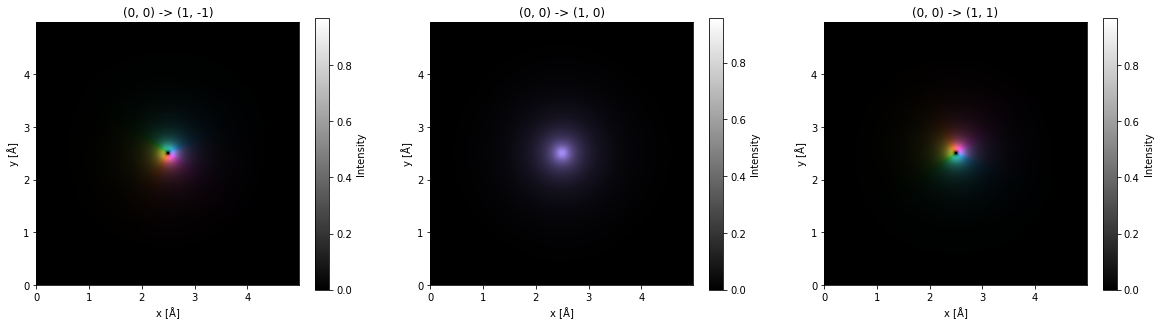

In [13]:
O_transitions = SubshellTransitions(Z = Z, n = n, l = l, xc = 'PBE',epsilon=1)
atomic_transition_potentials = O_transitions.get_transition_potentials(extent = 5,
                                                                       gpts = 256,
                                                                       energy = 100e3)

fig, axes = plt.subplots(1,3, figsize = (20,5))

for ax, atomic_transition_potential in zip(axes, atomic_transition_potentials):
    # print(str(atomic_transition_potential))
    atomic_transition_potential.show(ax = ax, title = str(atomic_transition_potential),cbar=True,cbar_label='Intensity')


In [14]:
import cplot
import numpy as np
def f(z):
    return np.sin(z ** 3) / z


plt = cplot.plot(
    f,
    (-2.0, +2.0),
    (-2.0, +2.0),
    400,
    # colorbars: bool = True,
    # abs_scaling="h-1.0",        # how to scale the lightness in domain coloring
    # colorspace: str = "cam16",  # ditto
    # abs/args contour lines:
    # contours=("auto", (-np.pi / 2, 0, np.pi / 2, np.pi)),
    # linecolors = "#a0a0a050",
    # linestyles = "solid",
    # linestyle_abs1 = "solid"
)
plt.show()

ModuleNotFoundError: No module named 'cplot'

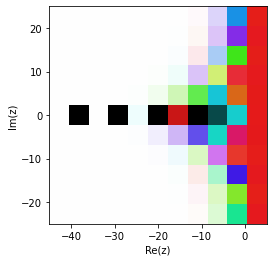

In [ ]:
import matplotlib.pyplot as plt
import mpmath
mpmath.cplot(mpmath.zeta, [-45,5],[-25,25], points=100)
# plt.colorbar()

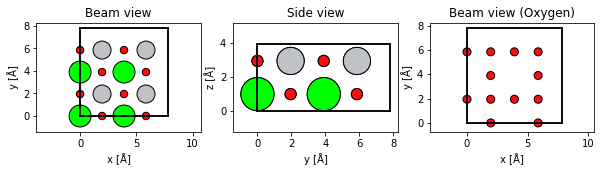

In [16]:
atoms = read('../data/srtio3_100.cif') * (2,2,1)
atoms.center(axis = 2)

from abtem import show_atoms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,2))

show_atoms(atoms, ax = ax1, title = 'Beam view')
show_atoms(atoms, ax = ax2, plane = 'yz', title = 'Side view')
show_atoms(atoms[atoms.numbers == 8], ax = ax3, plane = 'xy', title = 'Beam view (Oxygen)');


In [17]:
len(O_transitions)

3

In [18]:
transition_potential = TransitionPotential(O_transitions,
                                           atoms = atoms,
                                           sampling = .05,
                                           energy = 100e3,
                                           slice_thickness = 2)


In [19]:
transition_potential._calculate_potentials(0)

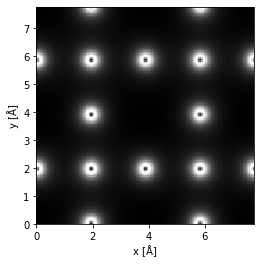

In [20]:
transition_potential.show()

In [21]:
S = SMatrix(energy = 100e3, semiangle_cutoff = 25) # interpolation not implemented!


detector = EELSDetector(collection_angle = 100, interpolation = 4)


potential = Potential(atoms, sampling = .05, slice_thickness = .5,
                      projection = 'infinite', parametrization = 'kirkland')


transition_potential = TransitionPotential(O_transitions)


scan = GridScan((0,0), potential.extent, sampling = .9*S.ctf.nyquist_sampling)


measurement = S.coreloss_scan(scan, detector, potential, transition_potential)

Forward multislice: 100%|██████████| 8/8 [00:02<00:00,  3.35it/s]


In [22]:
print(potential.extent,.9*S.ctf.nyquist_sampling)

(7.81, 7.81) 0.33312929356137355


In [23]:
s_array=scan.get_positions()
s_array

array([[0.        , 0.        ],
       [0.        , 0.32541667],
       [0.        , 0.65083333],
       ...,
       [7.48458333, 6.83375   ],
       [7.48458333, 7.15916667],
       [7.48458333, 7.48458333]])

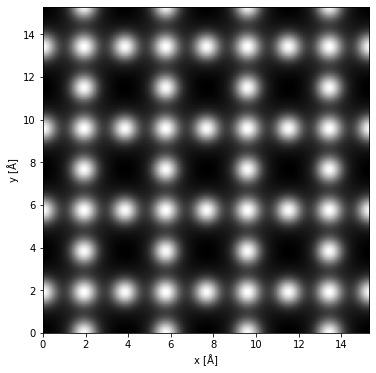

In [24]:
measurement.tile((2,2)).interpolate(.02).show(figsize = (6,6));

In [25]:
O_transitions = SubshellTransitions(Z = 8, n = 1, l = 0, xc = 'PBE')
Ti_transitions = SubshellTransitions(Z = 22, n = 2, l = 1, xc = 'PBE')
Sr_transitions = SubshellTransitions(Z = 38, n = 2, l = 1, xc = 'PBE')

transitions = [O_transitions, Ti_transitions, Sr_transitions]

transition_potential = TransitionPotential(transitions)

In [26]:
print('Oxygen:')
for bound_state, continuum_state in O_transitions.get_transition_quantum_numbers():
    print(f'(l, ml) = {bound_state} -> {continuum_state}')
print('Titanium:')
for bound_state, continuum_state in Ti_transitions.get_transition_quantum_numbers():
    print(f'(l, ml) = {bound_state} -> {continuum_state}')
print('Strontium:')
for bound_state, continuum_state in Sr_transitions.get_transition_quantum_numbers():
    print(f'(l, ml) = {bound_state} -> {continuum_state}')



Oxygen:
(l, ml) = (0, 0) -> (1, -1)
(l, ml) = (0, 0) -> (1, 0)
(l, ml) = (0, 0) -> (1, 1)
Titanium:
(l, ml) = (1, -1) -> (0, 0)
(l, ml) = (1, -1) -> (2, -2)
(l, ml) = (1, -1) -> (2, -1)
(l, ml) = (1, -1) -> (2, 0)
(l, ml) = (1, 0) -> (0, 0)
(l, ml) = (1, 0) -> (2, -1)
(l, ml) = (1, 0) -> (2, 0)
(l, ml) = (1, 0) -> (2, 1)
(l, ml) = (1, 1) -> (0, 0)
(l, ml) = (1, 1) -> (2, 0)
(l, ml) = (1, 1) -> (2, 1)
(l, ml) = (1, 1) -> (2, 2)
Strontium:
(l, ml) = (1, -1) -> (0, 0)
(l, ml) = (1, -1) -> (2, -2)
(l, ml) = (1, -1) -> (2, -1)
(l, ml) = (1, -1) -> (2, 0)
(l, ml) = (1, 0) -> (0, 0)
(l, ml) = (1, 0) -> (2, -1)
(l, ml) = (1, 0) -> (2, 0)
(l, ml) = (1, 0) -> (2, 1)
(l, ml) = (1, 1) -> (0, 0)
(l, ml) = (1, 1) -> (2, 0)
(l, ml) = (1, 1) -> (2, 1)
(l, ml) = (1, 1) -> (2, 2)


In [30]:
measurements = S.coreloss_scan(scan, detector, potential, transition_potential)

Forward multislice: 100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


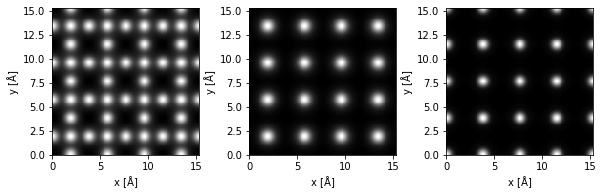

In [28]:
fig, (ax1, ax2, ax3)= plt.subplots(1, 3, figsize = (10,2.7))

measurements[0].tile((2, 2)).interpolate(.1).show(ax = ax1)
measurements[1].tile((2, 2)).interpolate(.1).show(ax = ax2)
measurements[2].tile((2, 2)).interpolate(.1).show(ax = ax3);

plt.savefig('low_res_eels.jpg', bbox_inches='tight')

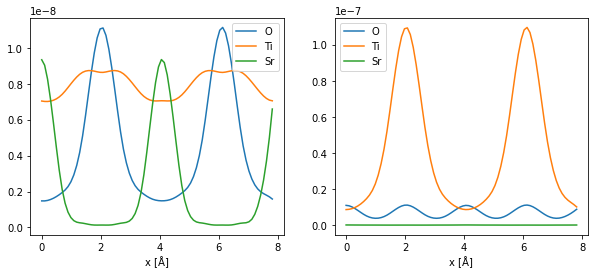

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,4))

measurements[0].interpolate_line((0,0), (0, potential.extent[1]),
                                 sampling = .1).show(ax = ax1, label = 'O')
measurements[1].interpolate_line((0,0), (0, potential.extent[1]),
                                 sampling = .1).show(ax = ax1, label = 'Ti')
measurements[2].interpolate_line((0,0), (0, potential.extent[1]),
                                 sampling = .1).show(ax = ax1, label = 'Sr')
ax1.legend()

measurements[0].interpolate_line((atoms[3].x, 0), (atoms[3].x,potential.extent[1]),
                                 sampling = .1).show(ax = ax2, label = 'O')
measurements[1].interpolate_line((atoms[3].x, 0),(atoms[3].x, potential.extent[1]),
                                 sampling = .1).show(ax = ax2, label = 'Ti')
measurements[2].interpolate_line((atoms[3].x, 0),(atoms[3].x,potential.extent[1]),
                                 sampling = .1).show(ax = ax2, label = 'Sr')
ax2.legend();